<small><i>May 2014 - This notebook was created by [Oriol Pujol Vila](http://www.maia.ub.es/~oriol). Source and license info are in the folder.</i></small>

# Machine Learning 2: Non-linear models and ensemble learning

1. Non-linear models
    * Nearest neighbor rule.
    * Decision Trees.
    * Kernel learning.

2. Ensemble learning
    * Introduction to ensemble learning
    * Bagging and Random Forest
    * Introduction to the multiclass problem and Error Correcting Output Coding

# 1. Non-linear models in Machine Learning

In our last case study, we shown that linear models can achive very good results. This is particularly true in datasets with large dimensionality. In those scenarios, the ratio between data and number of dimensions can be quite small. As a result we have a set of data spread out and it is very likely a linear model will be enough. However, it we have large amounts of data, this will not be enough. In those scenarios we may have to use non-linear models. 

In this notebook, we will introduce two concepts non-linearity and multi-class. Three models will be covered, Nearest Neighbors, Decision Trees and Kernel learning. We will apply these models to the predict **Customer Churn**. 

Let us first introduce the case study

# CASE STUDY: Customer Churn Analysis

Modeling churn means to understand what keeps the customer engaged to our product. Its analysis goal is to predict or describe the **churn rate** i.e. the rate at which customer leave or cease the subscription to a service. Its value lies in the fact that engaging new customers is often more costly than retaining existing ones. For that reason subscription business-based companies usually have proactive policies towards customer retention.

In this case study, we aim at building a machine learning based model for customer churn prediction on data from a Telecom company. Each row on the dataset represents a subscribing telephone customer. Each column contains customer attributes such as phone number, call minutes used during different times of day, charges incurred for services, lifetime account duration, and whether or not the customer is still a customer.

This case is partially inspired in Eric Chiang's analysis of churn rate. Data is available from the University of California Irvine machine learning repositories data set.


The complete set of attributes is the following:

+ State: categorical, for the 50 states and the District of Columbia
+ Account length: integer-valued, how long an account has been active 
+ Area code: categorical
+ Phone number: customer ID
+ International Plan: binary feature, yes or no
+ VoiceMail Plan: binary feature, yes or no
+ Number of voice mail messages: integer-valued
+ Total day minutes: continuous, minutes customer used service during the day
+ Total day calls: integer-valued
+ Total day charge: continuous
+ Total evening minutes: continuous, minutes customer used service during the evening
+ Total evening calls: integer-valued
+ Total evening charge: continuous
+ Total night minutes: continuous, minutes customer used service during the night
+ Total night calls: integer-valued
+ Total night charge: continuous
+ Total international minutes: continuous, minutes customer used service to make international calls
+ Total international calls: integer-valued
+ Total international charge: continuous
+ Number of calls to customer service: integer-valued

In [1]:
from __future__ import division
import pandas as pd
import numpy as np

churn_df = pd.read_csv('files/churn.csv')
col_names = churn_df.columns.tolist()

print ("Column names:")
print (col_names)

to_show = col_names[:6] + col_names[-6:]

print ("\nSample data:")
churn_df[to_show].head(6)

Column names:
['State', 'Account Length', 'Area Code', 'Phone', "Int'l Plan", 'VMail Plan', 'VMail Message', 'Day Mins', 'Day Calls', 'Day Charge', 'Eve Mins', 'Eve Calls', 'Eve Charge', 'Night Mins', 'Night Calls', 'Night Charge', 'Intl Mins', 'Intl Calls', 'Intl Charge', 'CustServ Calls', 'Churn?']

Sample data:


,State,Account Length,Area Code,Phone,Int'l Plan,VMail Plan,Night Charge,Intl Mins,Intl Calls,Intl Charge,CustServ Calls,Churn?
0,KS,128,415,382-4657,no,yes,11.01,10.0,3,2.70,1,False.
1,OH,107,415,371-7191,no,yes,11.45,13.7,3,3.70,1,False.
2,NJ,137,415,358-1921,no,no,7.32,12.2,5,3.29,0,False.
3,OH,84,408,375-9999,yes,no,8.86,6.6,7,1.78,2,False.
4,OK,75,415,330-6626,yes,no,8.41,10.1,3,2.73,3,False.
5,AL,118,510,391-8027,yes,no,9.18,6.3,6,1.70,0,False.


In [2]:
# Isolate target data
churn_result = churn_df['Churn?']
y = np.where(churn_result == 'True.',1,0)

# We don't need these columns
to_drop = ['State','Phone','Churn?']
churn_feat_space = churn_df.drop(to_drop,axis=1)

# 'yes'/'no' has to be converted to boolean values
# NumPy converts these from boolean to 1. and 0. later
yes_no_cols = ["Int'l Plan","VMail Plan"]
churn_feat_space[yes_no_cols] = churn_feat_space[yes_no_cols] == 'yes'

# Pull out features for future use
features = churn_feat_space.columns

X = churn_feat_space.as_matrix().astype(np.float)

print ("Feature space holds %d observations and %d features" % X.shape)
print ("Unique target labels:", np.unique(y))

Feature space holds 3333 observations and 18 features
Unique target labels: [0 1]


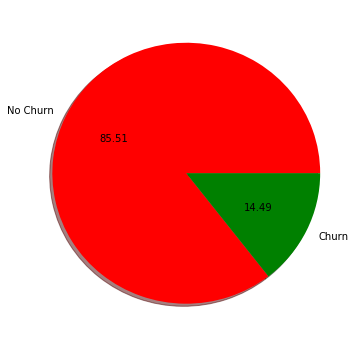

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.pie(np.c_[len(y)-np.sum(y),np.sum(y)][0],labels=['No Churn','Churn'],colors=['r','g'],shadow=True,autopct ='%.2f' )
fig = plt.gcf()
fig.set_size_inches(6,6)


In [4]:
#Save data for future use.
import pickle
ofname = open('churn_data.pkl', 'wb')
s = pickle.dump([X,y,features],ofname)
ofname.close()

<div class = "alert alert-success">**QUESTION: ** This kind of datasets are called **unbalanced** datasets. Name a trivial classifier with "good" accuracy in this data set?
</div>

<div class = "alert alert-info">
**Unbalanced datasets**
<p>
The unbalanced term describes the condition of the data where the ratio between the sizes of the positive and negative is a small value. In those scenarios, always predicting the majority class usually yields good accuracy performance, though it is ill informative. This kind of problems is very common when we want to model unusual events such as rare diseases, the occurrence of a failure in machinery, credit card fraud operations, etc. In those scenarios gathering data from usual events is very easy but collecting data from unusual events is difficult and results in a comparatively small size data set. In order to measure the performance on those data sets one has to use other performance metrics, such as specificity or positive predictive value on the minority class. In the end, the value of a misclassification of a sample depends on the application and the user. For example, in cancer detection because the cost of missing one patient in a trial is very large, we want the predictor to have very large sensitivity (we do not accept false negatives) though it means accepting more false positives. These false positives can be discarded in subsequent tests. 
</div>

# 2. Nearest Neighbors

Nearest neighbors is a member of the instance based learning and lazy Learning families. Instance based models base the model on the evaluation of a function that depends on the point we are querying and training data. Nearest Neighbors is the **simplest** of these techniques. The rationale behind this model is as follows: Each training data set can be seen as a solved case/problem. Thus, given a new problem instance we may retrieve the most *similar* case in our data set and apply the same solution. In the case of classification, this means that we select the label of the most similar data example in our training set.

/Users/oriol/anaconda/lib/python3.6/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


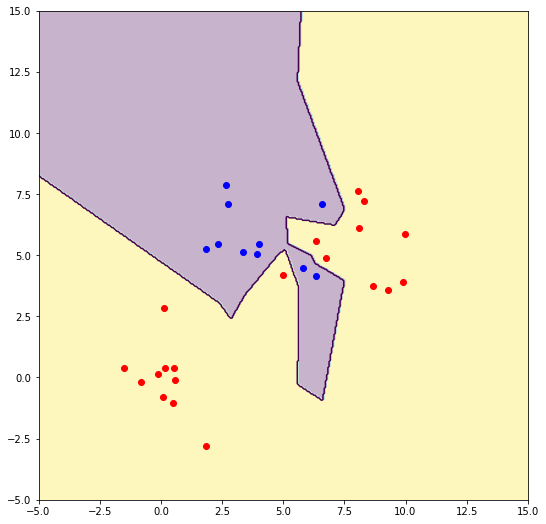

In [5]:
#Let's see what the boundary looks like in a toy problem.

MAXN=10
X = np.concatenate([1.25*np.random.randn(MAXN,2),5+1.5*np.random.randn(MAXN,2)]) 
X = np.concatenate([X,[8,5]+1.5*np.random.randn(MAXN,2)])
y = np.concatenate([np.ones((MAXN,1)),-np.ones((MAXN,1))])
y = np.concatenate([y,np.ones((MAXN,1))])
idxplus = y==1
idxminus = y==-1
plt.scatter(X[idxplus.ravel(),0],X[idxplus.ravel(),1],color='r')
plt.scatter(X[idxminus.ravel(),0],X[idxminus.ravel(),1],color='b')

from sklearn import cross_validation
from sklearn import neighbors
from sklearn import metrics

delta = 0.05
xx = np.arange(-5.0, 15.0, delta)
yy = np.arange(-5.0, 15.0, delta)
XX, YY = np.meshgrid(xx, yy)
Xf = XX.flatten()
Yf = YY.flatten()
sz=XX.shape
data = np.c_[Xf[:,np.newaxis],Yf[:,np.newaxis]];

#Evaluate the model for a given weight
clf = neighbors.KNeighborsClassifier(1)
clf.fit(X,y.ravel())
Z=clf.predict(data)
Z.shape=sz

plt.imshow(Z, interpolation='bilinear', origin='lower', extent=(-5,15,-5,15),alpha=0.3, vmin=-1, vmax=1)
plt.contour(XX,YY,Z,[0])
fig = plt.gcf()
fig.set_size_inches(9,9)

Observations:

+ The boundary is piece-wise linear. It is composed of edges of the Voronoi diagram.
+ Observe that the classifier perfectly fits the training data. Adding or removing one data point can largely change the boundary. This implies that the complexity of the method is large.
+ The key component of the nearest neigbors classifier is the notion of similarity/distance.

Remember that regularization explicitly models complexity. Regularization is usually a penalty term. In nearest neighbors we can penalize solutions with small "support" by using a majority voting on the $k$ closests data samples to the query sample.

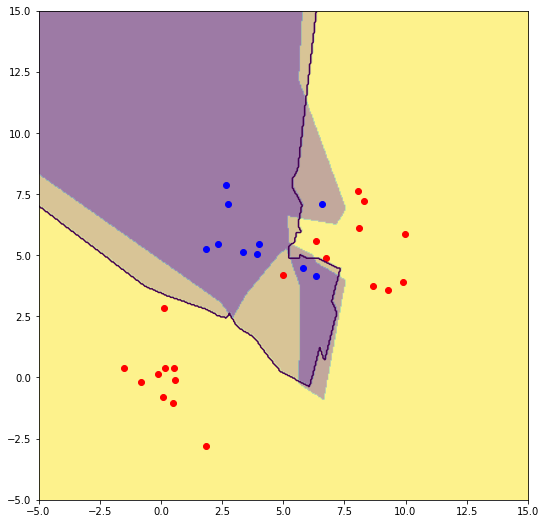

In [6]:
#Let's see what the boundary looks like in a toy problem.

plt.scatter(X[idxplus.ravel(),0],X[idxplus.ravel(),1],color='r')
plt.scatter(X[idxminus.ravel(),0],X[idxminus.ravel(),1],color='b')

clf = neighbors.KNeighborsClassifier(3)
clf.fit(X,y.ravel())
Z2=clf.predict(data)
Z2.shape=sz

plt.imshow(Z, interpolation='bilinear', origin='lower', extent=(-5,15,-5,15),alpha=0.4, vmin=-1, vmax=1)
plt.imshow(Z2, interpolation='bilinear', origin='lower', extent=(-5,15,-5,15),alpha=0.2, vmin=-1, vmax=1)

plt.contour(XX,YY,Z2,[0])
fig = plt.gcf()
fig.set_size_inches(9,9)

## 2.1 Churn classification with nearest neighbors.

So let us head back to analyzing the problem of customer churn prediction. We may fit a 1-Nearest Neighbor classifier and check the result.

In [8]:
#Recover Churn data
import pickle
fname = open('churn_data.pkl','rb')
data = pickle.load(fname)
X = data[0]
y = data[1]
print ('Loading ok.')

Loading ok.


In [10]:
from sklearn import model_selection
from sklearn import neighbors
from sklearn import metrics
acc = np.zeros((5,))
i=0
kf=model_selection.KFold(n_splits=5, shuffle=False, random_state=0)
kf.get_n_splits()
#We will build the predicted y from the partial predictions on the test of each of the folds
yhat = y.copy()
for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    dt = neighbors.KNeighborsClassifier(n_neighbors=1)
    dt.fit(X_train,y_train)
    yhat[test_index] = dt.predict(X_test)
    acc[i] = metrics.accuracy_score(yhat[test_index], y_test)
    i=i+1
print ('Mean accuracy: '+ str(np.mean(acc)))


Mean accuracy: 0.810678444562


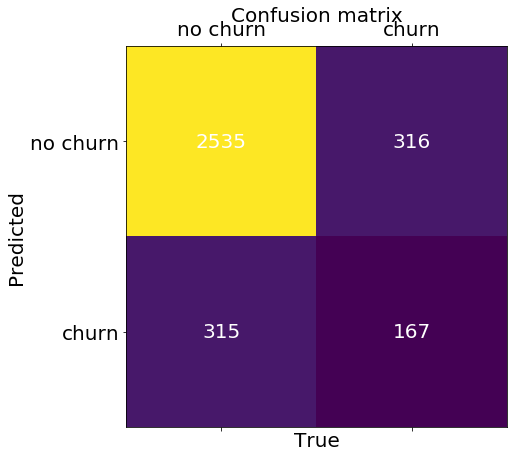

             precision    recall  f1-score   support

          0       0.89      0.89      0.89      2850
          1       0.35      0.35      0.35       483

avg / total       0.81      0.81      0.81      3333



In [13]:
def draw_confusion(y,yhat,labels):
    cm = metrics.confusion_matrix(y, yhat)
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.matshow(cm)
    plt.title('Confusion matrix',size=20)
    ax.set_xticklabels([''] + labels, size=20)
    ax.set_yticklabels([''] + labels, size=20)
    plt.ylabel('Predicted',size=20)
    plt.xlabel('True',size=20)
    for i in range(2):
        for j in range(2):
            ax.text(i, j, cm[i,j], va='center', ha='center',color='white',size=20)
    fig.set_size_inches(7,7)
    plt.show()

draw_confusion(y,yhat,['no churn', 'churn'])
print (metrics.classification_report(y,yhat))

This is quite a bad result. Remember that by always selecting class 'no churn' we should get around $85\%$ of accuracy. As it was noticed before the definition of distance is critical. In NN we are using Euclidean distance. Distances assume that all variables operate at the same scale, i.e. all are commensurable. A change in one unit in one of the variables is equivalent to/as important as a change of 1 unit in the other. In this data set, this does not happen. For example, area codes values are around 400 while whether the customer enjoys an international plan take values 0 and 1. Thus, we may account for these changes by scaling the features. The most standard way of doing this is feature normalization or standarization. In this preprocessing technique each feature is scaled to have zero mean and unit standard deviation.

In [14]:
# Standarize
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [17]:
from sklearn import metrics
acc_snooping = np.zeros((5,))
i=0
kf=model_selection.KFold(n_splits=5, shuffle=False, random_state=0)
kf.get_n_splits()
#We will build the predicted y from the partial predictions on the test of each of the folds
yhat = y.copy()
for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    dt = neighbors.KNeighborsClassifier(1)
    dt.fit(X_train,y_train)
    yhat[test_index] = dt.predict(X_test)
    acc_snooping[i] = metrics.accuracy_score(yhat[test_index], y_test)
    i=i+1
print ('Mean accuracy: '+ str(np.mean(acc_snooping)))


Mean accuracy: 0.864689276983


<div class="alert alert-error"> **QUESTION:** In the former process we have accidentally snooped into the data and the result is contaminated. Where?</div>

In [19]:
#NO SNOOPING
acc = np.zeros((5,))
i=0
#We will build the predicted y from the partial predictions on the test of each of the folds
yhat = y.copy()
for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    dt = neighbors.KNeighborsClassifier(1)
    dt.fit(X_train,y_train)
    X_test = scaler.transform(X_test)
    yhat[test_index] = dt.predict(X_test)
    acc[i] = metrics.accuracy_score(yhat[test_index], y_test)
    i=i+1
print ('Mean accuracy: '+ str(np.mean(acc)))

Mean accuracy: 0.864388526457


[<matplotlib.text.Text at 0x110d12278>, <matplotlib.text.Text at 0x110d2b860>]

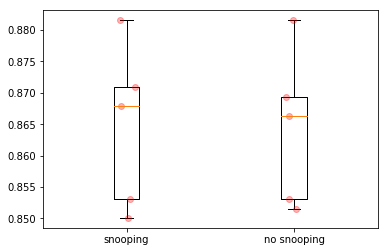

In [20]:
acct=np.c_[acc_snooping,acc]
plt.boxplot(acct);
for i in range(2):
    xderiv = (i+1)*np.ones(acct[:,i].shape)+(np.random.rand(5,)-0.5)*0.1
    plt.plot(xderiv,acct[:,i],'ro',alpha=0.3)
ax = plt.gca()
ax.set_xticklabels(['snooping', 'no snooping'])

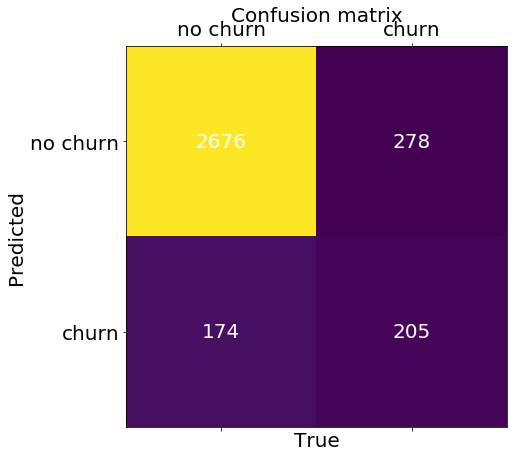

             precision    recall  f1-score   support

          0       0.91      0.94      0.92      2850
          1       0.54      0.42      0.48       483

avg / total       0.85      0.86      0.86      3333



In [22]:
def draw_confusion(y,yhat,labels):
    cm = metrics.confusion_matrix(y, yhat)
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.matshow(cm)
    plt.title('Confusion matrix',size=20)
    ax.set_xticklabels([''] + labels, size=20)
    ax.set_yticklabels([''] + labels, size=20)
    plt.ylabel('Predicted',size=20)
    plt.xlabel('True',size=20)
    for i in range(2):
        for j in range(2):
            ax.text(i, j, cm[i,j], va='center', ha='center',color='white',size=20)
    fig.set_size_inches(7,7)
    plt.show()

draw_confusion(y,yhat,['no churn', 'churn'])
print (metrics.classification_report(y,yhat))

## 2.1.1 A brief description of the confusion matrix

This result is much better. As we have seen accuracy can be a little informative in some problems. For this reason we may use other performance measures. Classic performance measures can be derived from the confusion matrix. Consider the following confusion matrix:

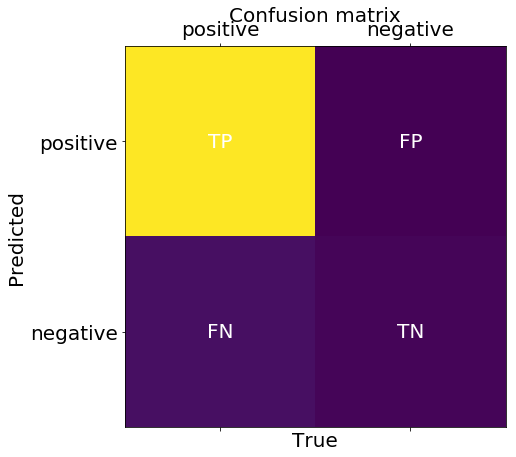

In [23]:
def draw_confusion(y,yhat,labels):
    cm = metrics.confusion_matrix(y, yhat)
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.matshow(cm)
    plt.title('Confusion matrix',size=20)
    ax.set_xticklabels([''] + labels, size=20)
    ax.set_yticklabels([''] + labels, size=20)
    plt.ylabel('Predicted',size=20)
    plt.xlabel('True',size=20)
    ax.text(0, 0, 'TP', va='center', ha='center',color='white',size=20)
    ax.text(0, 1, 'FN', va='center', ha='center',color='white',size=20)
    ax.text(1, 0, 'FP', va='center', ha='center',color='white',size=20)
    ax.text(1, 1, 'TN', va='center', ha='center',color='white',size=20)            
    fig.set_size_inches(7,7)
    plt.show()

draw_confusion(y,yhat,['positive', 'negative'])

The matrix is divided in four quarters and contains

+ True Positives (TP): Positive samples predicted as such.
+ True Negatives (TN): Negative samples predicted as such.
+ False Positives (FP): Negative samples predicted as positive.
+ False Negatives (FN): Positive samples predicted as negative.

The combination of these elements allows to define several performance metrics:

+ Accuracy: 

$$\text{accuracy}=\frac{\text{TP}+\text{TN}}{\text{TP}+\text{TN}+\text{FP}+\text{FN}}$$

Column-wise we find these two partial performance metrics:

+ Sensitivity or Recall: 

$$\text{sensitivity}=\frac{\text{TP}}{\text{Real Positives}}=\frac{\text{TP}}{\text{TP}+\text{FN}}$$

+ Specificity:

$$\text{specificity}=\frac{\text{TN}}{\text{Real Negatives}}=\frac{\text{TN}}{\text{TN}+\text{FP}}$$

Row-wise we find these two partial performance metrics:

+ Precision or Positive Predictive Value:

$$\text{precision}=\frac{\text{TP}}{\text{Predicted Positives}}=\frac{\text{TP}}{\text{TP}+\text{FP}}$$

+ Negative predictive value:

$$\text{NPV}=\frac{\text{TN}}{\text{Predicted Negative}}=\frac{\text{TN}}{\text{TN}+\text{FN}}$$

The concept of positive and negative samples is purely arbitrary, thus we really have to remember the concepts of precision/positive predictive value and sensitivity/recall. 

In [24]:
# Let us check the concepts with churn as the positive class
TP = np.sum(np.logical_and(yhat==1,y==1))
TN = np.sum(np.logical_and(yhat==0,y==0))
FP = np.sum(np.logical_and(yhat==1,y==0))
FN = np.sum(np.logical_and(yhat==0,y==1))

print ('TP: ' + str(TP))
print ('TN: ' + str(TN))
print ('FP: ' + str(FP))
print ('FN: ' + str(FN))
print ('sensitivity/recall: '+ str(TP/(TP+FN)))
print ('precision: '+ str(TP/(TP+FP)))


TP: 205
TN: 2676
FP: 174
FN: 278
sensitivity/recall: 0.424430641822
precision: 0.540897097625


### 2.1.2 Analyzing the confusion matrix in our problem

Our goal is to predict custormer churn, thus we may ask how often the classifier correctly predicts it. We will consider "churn" as the positive class. The question we are wondering about is the ratio between the $TP$ and all the $\text{Real Positives}$. This is the *sensitivity* or *recall*. We are able to correctly predict $187/(187+296) = 0.39$ of the customers that cease the service. Observe that this value is consistent with the classification report when checking recall for class $1$.

However, we have to trade-off this value with *precision*. Precision answers the question, from all the customers we predict will churn, which is the ratio of those that actually churn? This effectively tells us the price we are paying in terms of how many non-churn customers are being predicted as quitters. If we check this value, we can see it is $187/(187+59) = 76\%$. This means that about 1 out 4 customers predicted as churn are not quitting the service.

<div class="alert alert-info"> **Nearest Neighbors**
<p>
<ul>
<li> One of the simplest classifiers.
<li> Smoothness of the model is governed by the number of the neighbors.
<li> Hyper-parameter $k$ or $p$ in the $\ell_p$ norm are set by cross-validation.
</ul>
</div>

# 3. Decision trees

Decision trees are another kind of intutive classification strategy based on the divide and conquer paradigm. 

The basic **idea** in decision trees is to partition the space in patches and fit a model in that patch. There are two questions to answer in order to implement this solution:

+ How do we partition the space?
+ What model to use in each patch?

In classification trees the second question is straight forward, each patch is given the value of a label and all data falling in that part of the space will be predicted as such.

## 3.1 Decision tree modeling

Elements:

- Splits using axis-orthogonal hyperplanes. This is the key that allows interpretability of the results.

- At each internal node we test a value of a feature. A feature and a threshold are stored for each internal node.  

- Leaves makes the class prediction. If leaves are pure, we have to store the class label. If leaves are impure, then the fraction of samples for each class is stored and its frequency is returned when queried.



### 3.1.1 Building our intuition on decision trees

Let us build up our intuition with a simple example.

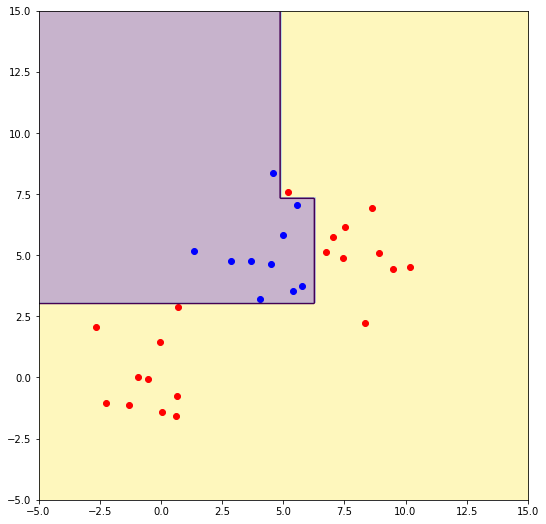

In [25]:
%matplotlib inline
#Let's see what the boundary looks like in a toy problem.
%reset -f
import numpy as np
import matplotlib.pyplot as plt
MAXN=10
np.random.seed(2)
X = np.concatenate([1.25*np.random.randn(MAXN,2),5+1.5*np.random.randn(MAXN,2)]) 
X = np.concatenate([X,[8,5]+1.5*np.random.randn(MAXN,2)])
y = np.concatenate([np.ones((MAXN,1)),-np.ones((MAXN,1))])
y = np.concatenate([y,np.ones((MAXN,1))])
idxplus = y==1
idxminus = y==-1
plt.scatter(X[idxplus.ravel(),0],X[idxplus.ravel(),1],color='r')
plt.scatter(X[idxminus.ravel(),0],X[idxminus.ravel(),1],color='b')

from sklearn import tree
from sklearn import metrics

delta = 0.05
xx = np.arange(-5.0, 15.0, delta)
yy = np.arange(-5.0, 15.0, delta)
XX, YY = np.meshgrid(xx, yy)
Xf = XX.flatten()
Yf = YY.flatten()
sz=XX.shape
data = np.c_[Xf[:,np.newaxis],Yf[:,np.newaxis]];
clf = tree.DecisionTreeClassifier(random_state=0)
clf.fit(X,y.ravel())
Z=clf.predict(data)
Z.shape=sz

plt.imshow(Z, interpolation='bilinear', origin='lower', extent=(-5,15,-5,15),alpha=0.3, vmin=-1, vmax=1)
plt.contour(XX,YY,Z,[0])
fig = plt.gcf()
fig.set_size_inches(9,9)

In [26]:
#Export Tree
import os
dotfile = tree.export_graphviz(clf, out_file = "toy_tree.dot")

os.system("dot -Tpng toy_tree.dot -o toy_tree.png")

32512

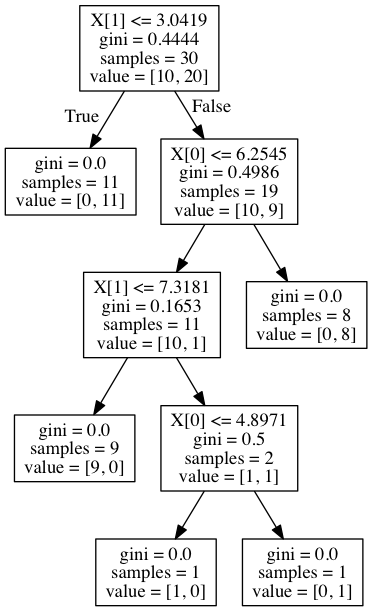

In [27]:
from IPython.core.display import Image
Image("toy_tree.png")

Let us check the meaning of the tree. The first node splits the training set using feature $1$ by applying the threshold $\leq 3.04$. As a result we are able to correctly classify eleven of the thirty data points. Let us see the boundary in that case.

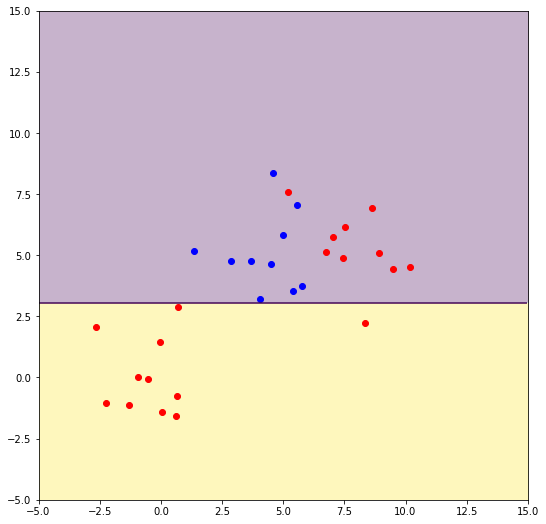

In [28]:
clf = tree.DecisionTreeClassifier(random_state=0,max_depth=1)
clf.fit(X,y.ravel())
Z=clf.predict(data)
Z.shape=sz

plt.scatter(X[idxplus.ravel(),0],X[idxplus.ravel(),1],color='r')
plt.scatter(X[idxminus.ravel(),0],X[idxminus.ravel(),1],color='b')


plt.imshow(Z, interpolation='bilinear', origin='lower', extent=(-5,15,-5,15),alpha=0.3, vmin=-1, vmax=1)
plt.contour(XX,YY,Z,[0])
fig = plt.gcf()
fig.set_size_inches(9,9)

The second node splits the training set using feature $0$ by applying the threshold $\leq 6.25$. Note that this only is used in the part of the space where feature $1$ is greater  than $3.04$. Observe that the remaining blue space is characterized by the following logical function: $(x_1>3.04) \wedge (x_0\leq 6.25)$

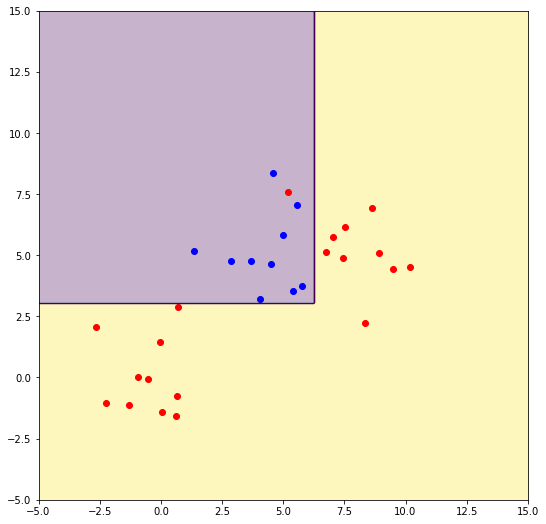

In [29]:
clf = tree.DecisionTreeClassifier(random_state=0, max_depth=2)
clf.fit(X,y.ravel())
Z=clf.predict(data)
Z.shape=sz

plt.scatter(X[idxplus.ravel(),0],X[idxplus.ravel(),1],color='r')
plt.scatter(X[idxminus.ravel(),0],X[idxminus.ravel(),1],color='b')

plt.imshow(Z, interpolation='bilinear', origin='lower', extent=(-5,15,-5,15),alpha=0.3, vmin=-1, vmax=1)
plt.contour(XX,YY,Z,[0])
fig = plt.gcf()
fig.set_size_inches(9,9)

What is great about decision trees?

+ Trees are easy for humans to interpret. It can be seen as a set of rules. Each path from root to one leaf of the tree is an AND combination of the thresholded features.
+ Given a finite data set, decision trees can express any function of the input attributes. In ${\bf R}^d$ we can isolate every point in the data set by constructing a box around each of them.
+ There can be more than one tree that fits the same data. From all of them we would like a tree with minimum number of nodes. But the problem is NP.

### 3.1.2 Learning the tree

Because the problem is NP we can resort to a greedy construction algorithm. Greedy algorithms choose the current best binary partition without taking into account its impact on the quality of subsequent splits.

The algorithm idea is as follows:

+ Initialize the algorithm with a node associated to the full data set. 

**while** the list is not empty
1. Retrieve the first node from the list.
2. Find the data associated to that node.
3. Find a splitting point.
4. If the node is splittable, create the nodes linked to the parent node and put them in the exploration list.

#### The splitting criterion

There are many different splitting criteria. The most common ones are:

+ Misclassification error
+ Gini index
+ Cross-entropy/Information gain/Mutual information

Withouth going into details, misclassification error splits greedily select the split that corrects more data at each point. Gini index and cross-entropy probabilistically model the notion of impurity of a node. The split is chosen so that the average purity of the new nodes is maximized. Observe that as we descend in the tree the purity increases and eventually converge to pure leaves. A nice way of thinking about entropy is Pedro Domingos' simile with surprise. Entropy measures the average surprise/information a probabilistic result yields. In a binary variable, the maximum surprise occurs when both outcomes are equally probable, one has the maximum uncertainty on the result. Otherwise, the surprise decreases. This behavior is also display in Gini's index.

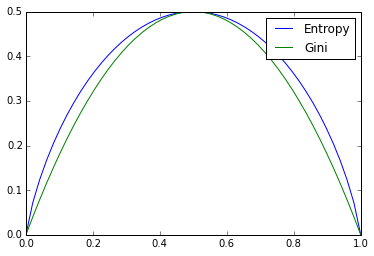

In [24]:
import numpy as np
entropy = lambda p: -np.sum(p * np.log2(p)) if not 0 in p else 0
gini = lambda p: 1. - (np.array(p)**2).sum()
pvals = np.linspace(0, 1)        
plt.plot(pvals, [entropy([p,1-p])/2. for p in pvals], label='Entropy')
plt.plot(pvals, [gini([p,1-p]) for p in pvals], label='Gini')
plt.legend()

### 3.1.3 Trees and overfitting

Because trees are very expressive models they can model any training set perfectly and easily overfit.

There are two ways of avoiding overfitting in trees:

+ Stop growing the tree when the split is not statistically significant.
+ Grow a full tree and post-prune.

One of the simplest ways of post pruning is "reduced error prunning". It goes like this,

1. Split data into training and validation
2. Create a candidate tree on the training set
3. Do until further pruning is harmful
    1. Evaluate impact on the validation set of removing each posible node (with descendants)
    2. Greedily remove the node that improves the performance the most.
    
Pruning is not implemented in sklearn at this moment. However let us check what happens in our customer churn prediction problem when we use a decision tree.

In [30]:
%reset -f
#Recover Churn data
import pickle
fname = open('churn_data.pkl','rb')
data = pickle.load(fname)
X = data[0]
y = data[1]
features = data[2]
print ('Loading ok.')

Loading ok.


In [33]:
#NO SNOOPING
import numpy as np
from sklearn import model_selection
from sklearn.preprocessing import StandardScaler
from sklearn import tree
from sklearn import metrics


kf=model_selection.KFold(n_splits=5, shuffle=False, random_state=0)
kf.get_n_splits()
acc = np.zeros((5,))
i=0
#We will build the predicted y from the partial predictions on the test of each of the folds
yhat = y.copy()
for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    dt = tree.DecisionTreeClassifier(criterion='entropy')
    dt.fit(X_train,y_train)
    X_test = scaler.transform(X_test)
    yhat[test_index] = dt.predict(X_test)
    acc[i] = metrics.accuracy_score(yhat[test_index], y_test)
    i=i+1
print ('Mean accuracy: '+ str(np.mean(acc)))

Mean accuracy: 0.91629500565


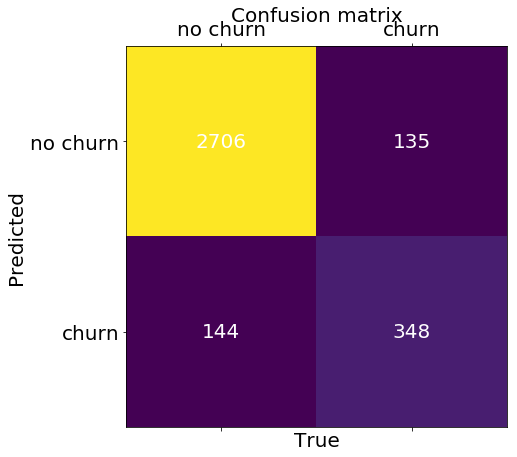

             precision    recall  f1-score   support

          0       0.95      0.95      0.95      2850
          1       0.71      0.72      0.71       483

avg / total       0.92      0.92      0.92      3333



In [35]:
import matplotlib.pyplot as plt
def draw_confusion(y,yhat,labels):
    cm = metrics.confusion_matrix(y, yhat)
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.matshow(cm)
    plt.title('Confusion matrix',size=20)
    ax.set_xticklabels([''] + labels, size=20)
    ax.set_yticklabels([''] + labels, size=20)
    plt.ylabel('Predicted',size=20)
    plt.xlabel('True',size=20)
    for i in range(2):
        for j in range(2):
            ax.text(i, j, cm[i,j], va='center', ha='center',color='white',size=20)
    fig.set_size_inches(7,7)
    plt.show()

draw_confusion(y,yhat,['no churn', 'churn'])
print (metrics.classification_report(y,yhat))

In [36]:
# Let us check the concepts with churn as the positive class
TP = np.sum(np.logical_and(yhat==1,y==1))
TN = np.sum(np.logical_and(yhat==0,y==0))
FP = np.sum(np.logical_and(yhat==1,y==0))
FN = np.sum(np.logical_and(yhat==0,y==1))

print ('TP: ' + str(TP))
print ('TN: ' + str(TN))
print ('FP: ' + str(FP))
print ('FN: ' + str(FN))
print ('sensitivity/recall: '+ str(TP/(TP+FN)))
print ('precision: '+ str(TP/(TP+FP)))

TP: 348
TN: 2706
FP: 144
FN: 135
sensitivity/recall: 0.72049689441
precision: 0.707317073171


Observe that by using a decision tree, the recall increased by $30\%$ while having the precision at a simliar level than nearest neighbors. Let us check the first levels of the tree.

In [37]:
import os
#Let us check the the first three levels of the tree. GraphViz and PyDot are needed.
dt = tree.DecisionTreeClassifier(criterion='entropy', max_depth=3)
scaler = StandardScaler()
Xs = scaler.fit_transform(X)
dt.fit(Xs,y)

#Export Tree

dotfile = tree.export_graphviz(dt, out_file = "churn.dot", feature_names = features)


os.system("dot -Tpng churn.dot -o churn.png")

32512

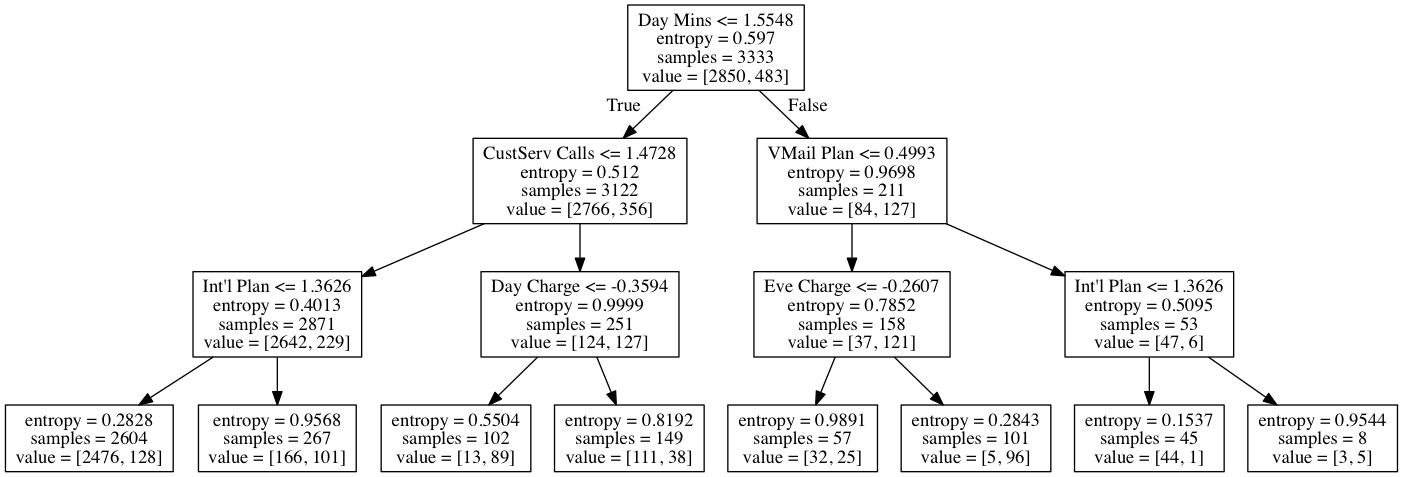

In [38]:
from IPython.core.display import Image
Image("churn.png")

Observe the first feature split and the values of the entropy according to the split.

In [40]:
entropy = lambda p: -np.sum(p * np.log2(p)) if not 0 in p else 0

#Let us check the entropy on the root node
#There are 2850 samples of customers that stay in the company. The frequency is
proot = 2850/3333
#And the entropy value is
print( 'Root node entropy: '+ str(entropy([proot,1-proot])))

#After the split we have the following frequencies for the left and right children
pleft = np.sum([2476,166,13,111])/3122 #Frequency of label 0 on the left node
pright = np.sum([32,5,44,3])/211 #Frequency of label 0 on the right node

print( 'Left node entropy: '+ str(entropy([pleft,1-pleft])))
print ('Right node entropy: '+ str(entropy([pright,1-pright])))

#Information gain computes the difference between the entropy of the parent and the weighed entropies of the children
# I = H_root - \sum freq_i * H_i

I = entropy([proot,1-proot]) - 3122/3333*entropy([pleft,1-pleft])+211/3333*entropy([pright,1-pright])

print ('Information gain: '+ str(I))



Root node entropy: 0.5969661118
Left node entropy: 0.511951672828
Right node entropy: 0.969830853477
Information gain: 0.178820653508


The split reduces the average entropy of the children, thus the splits are more pure.

Observations:

+ Observe that because we have restricted (for visualization purposes) the maximum depth of the tree, the leaves are not pure. 
+ Analyzing the leaves we can see that most of the clients that are hooked to the plan share the following conditions:

$$(\text{Day Charge} \leq 1.5) \wedge (\text{Customer Service Calls} \leq 1.47) \wedge (\text{International Plan} \leq 1.36)$$

Note that these values are preprocessed and as such they convey little interpretable information. Thus, in order to make sense of the former conditions we have to invert the transformation. We can do it in several ways, one way is to use interpolation and query for the feature of interest.

Day Charge < 44.912277594
Customer service calls <3.49633800503
International Plan < nan


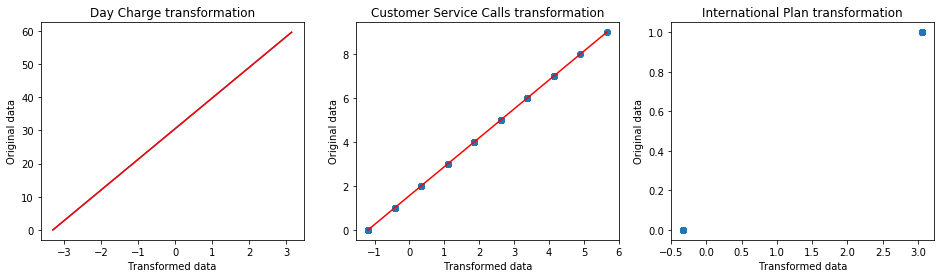

In [41]:
from scipy import interpolate
import numpy as np
import matplotlib.pyplot as plt
idx_global = features.tolist()

#Day Charge
plt.subplot(1,3,1)
idx = idx_global.index('Day Charge')
selection = X[:,idx]
idx_sort = np.argsort(selection)
plt.plot(Xs[idx_sort,idx], X[idx_sort,idx])
spline = interpolate.UnivariateSpline(x=Xs[idx_sort,idx], y=X[idx_sort,idx])
plt.plot(Xs[idx_sort,idx],spline(Xs[idx_sort,idx]),'r')
plt.title('Day Charge transformation')
ax = plt.gca()
ax.set_xlabel('Transformed data')
ax.set_ylabel('Original data')
print ('Day Charge < '+str(spline([1.55])[0]))


#CustServ Calls
plt.subplot(1,3,2)
idx = idx_global.index('CustServ Calls')
selection = X[:,idx]
idx_sort = np.argsort(selection)
plt.plot(Xs[idx_sort,idx], X[idx_sort,idx],'o')
spline = interpolate.UnivariateSpline(x=Xs[idx_sort,idx], y=X[idx_sort,idx])
plt.plot(Xs[idx_sort,idx],spline(Xs[idx_sort,idx]),'r')
plt.title('Customer Service Calls transformation')
ax = plt.gca()
ax.set_xlabel('Transformed data')
ax.set_ylabel('Original data')
print ('Customer service calls <' + str(spline([1.47])[0]))

#International Plan
plt.subplot(1,3,3)
idx = idx_global.index("Int'l Plan")
selection = X[:,idx]
idx_sort = np.argsort(selection)
plt.plot(Xs[idx_sort,idx], X[idx_sort,idx],'o')
spline = interpolate.UnivariateSpline(x=Xs[idx_sort,idx], y=X[idx_sort,idx])
plt.plot(Xs[idx_sort,idx],spline(Xs[idx_sort,idx]),'r')
plt.title('International Plan transformation')
ax = plt.gca()
ax.set_xlabel('Transformed data')
ax.set_ylabel('Original data')
print ('International Plan < ' + str(spline([1.36])[0]))

fig = plt.gcf()
fig.set_size_inches(16,4)

Thus the final profile for the 2476 customers that do not churn has in common:

$$(\text{Day Charge} \leq 45) \wedge (\text{Customer Service Calls} < 4) \wedge (\text{International Plan}= \text{NO})$$

# 4. Extending Support Vector Machines to the Non-Linear Case. A very brief introduction to kernels.

We have seen that a linear model in the parameters can model non-linear boundaries provided we **explicitly** map original data non-linearly. For example, we can create a linear model with features squared. This will lead to a quadratic boundary with respect to the original space. There is another way of **implicitly** encoding non-linearities by means of **kernels**.

The kernel encodes the notion of similarity between two data points. 

The change in the formulation involve the introduction of several concepts from mathematical analysis. For the sake of simplicity, we will skip the details (read "The story of a kernel" in the following paragraph or ask any detail if you are curious).

As a result, any regularized cost function optimization problem such as SVM has a solution of following form,

$$f(x) = \sum\limits_{i=1}^N \alpha_i k(x_i,x)$$


<div class = "alert alert-info">**The story of a kernel**
<p>
*Disclaimer: This is  a highly mathematically non rigorous story of how kernels come into play in machine learning.*
<p>
At some point we talked about keeping complexity in check. For that purpose we need to measure complexity. And we saw that certain models, such as linear models can control it using the norm of weights. To the fact of adding this penalty to the objective function we are optimizing is called *regularization*.
<p>
However, it would be great to be able to measure the complexity of any function. To address this issue we have to resort to functional analysis. Functional analysis is a brach of mathematical analyisis that deals with spaces of functions. For that purpose a Hilbert space must be introduced so that similarity and distance among functions can be measured. A Hilbert space is a complete vector space with inner product. Intuitively, it generalizes the classical Euclidean space to infinite dimensions, and thus, to functional spaces.
<p>
One particular functional space is the Reproducing Kernel Hilbert Space (RKHS). In this space a function evaluated on a point $x$ is defined by the inner product of the function and the kernel evaluated on that point, i.e. $f(x) = \langle f(\cdot),K(x,\cdot) \rangle$, where $K$ is the kernel. This is called Riesz representation and it is the key for showing the most important result for our problems, *The Representer's theorem*.
<p>
The Respresenter's theorem states that the solution of any problem with the following form 
$$
	f^*=\underset{f\in \mathcal{H}}{\operatorname{arg\,min}}\frac{1}{n}\sum_i{\mathcal{L}(f(x_i),y_i)}+\lambda\|f\|_{\mathcal{H}}^2
	$$
is given by
$$f(x) = \sum\limits_{i=1}^N \alpha_i k(x_i,x)$$
where $x_i$ are our samples. 
</div>
    

The kernel has to be a positive semi-definite function, such as:

+ Linear kernel: $$k(x_i,x_j) = x_i^Tx_j$$
+ Polynomial kernel: $$k(x_i,x_j) = (1+ x_i^Tx_j)^p$$
+ Radial Basis Function kernel $$k(x_i,x_j) = e^{-\frac{\|x_i-x_j\|^2}{2\sigma^2}}$$


<div class = "alert alert-error"> On a practical side you can define a kernel by using your favorite distance $d(x_i,x_j)$ and defining the kernel as
$$k(x_i,x_j) = e^{-\gamma d(x_i,x_j)}, \quad \gamma>0$$
where $\gamma$ is a hyper-parameter that controls the decay of the exponential (we will tune it using cross-validation). Observe that RBF is an instantiation of this more general rule.
</div>

As comented before, kernels implicitly encode a non-linear transformation and remember that SVM finds the optimal hyperplane. By combining both concepts we have a linear method applied on a data on a transformed space, but we do not have to provide the explicit transformation.

This becomes incredibly useful when one realizes that the feature mapping from a radial basis function kernel is a maping into a $\infty$-dimensional space.

Le us build our intuition about how kernels work with the following video:

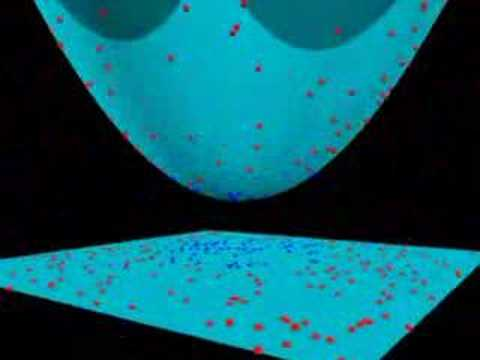

In [42]:
from IPython.display import YouTubeVideo
YouTubeVideo('3liCbRZPrZA', size=700)

Let us try it in a toy problem.

<function __main__.SVC_gamma>

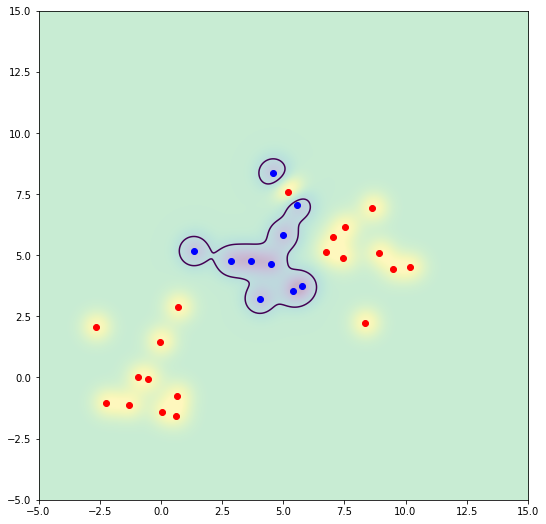

In [43]:
#Let's see what the boundary looks like in a toy problem.
%matplotlib inline
%reset -f
import numpy as np
import matplotlib.pyplot as plt
MAXN=10
np.random.seed(2)
X = np.concatenate([1.25*np.random.randn(MAXN,2),5+1.5*np.random.randn(MAXN,2)]) 
X = np.concatenate([X,[8,5]+1.5*np.random.randn(MAXN,2)])
y = np.concatenate([np.ones((MAXN,1)),-np.ones((MAXN,1))])
y = np.concatenate([y,np.ones((MAXN,1))])
idxplus = y==1
idxminus = y==-1

from sklearn import svm
from sklearn import metrics

delta = 0.05
xx = np.arange(-5.0, 15.0, delta)
yy = np.arange(-5.0, 15.0, delta)
XX, YY = np.meshgrid(xx, yy)
Xf = XX.flatten()
Yf = YY.flatten()
sz=XX.shape
data = np.c_[Xf[:,np.newaxis],Yf[:,np.newaxis]];

def SVC_gamma(gamma, C):
    clf = svm.SVC(kernel = 'rbf', gamma = gamma, C = C)
    clf.fit(X,y.ravel())
    Z=clf.decision_function(data)
    Z.shape=sz
    plt.scatter(X[idxplus.ravel(),0],X[idxplus.ravel(),1],color='r')
    plt.scatter(X[idxminus.ravel(),0],X[idxminus.ravel(),1],color='b')
    plt.imshow(Z, interpolation='bilinear', origin='lower', extent=(-5,15,-5,15),alpha=0.3, vmin=-1, vmax=1)
    plt.contour(XX,YY,Z,[0])
    fig = plt.gcf()
    fig.set_size_inches(9,9)

from IPython.html.widgets import interact    
interact(SVC_gamma, gamma=(0.011,5.,0.01), C = (0.01,2))

# 4.1 Application to customer churn prediction

Let us apply the RBF kernel SVM to the customer churn prediction. Usually, discriminant classifiers are not affine invariant and we have to consider some feature normalization process. For the sake of fairness, we will use the same standarization method.

In [44]:
%reset -f
#Recover Churn data
import pickle
fname = open('churn_data.pkl','rb')
data = pickle.load(fname)
X = data[0]
y = data[1]
features = data[2]
print ('Loading ok.')

Loading ok.


In [47]:
#NO SNOOPING
import numpy as np
from sklearn import model_selection
from sklearn.preprocessing import StandardScaler
from sklearn import svm
from sklearn import metrics


kf=model_selection.KFold(n_splits=5,  shuffle=False, random_state=0)
kf.get_n_splits(X)
acc = np.zeros((5,))
i=0
#We will build the predicted y from the partial predictions on the test of each of the folds
yhat = y.copy()
for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    #Standard parameters
    clf = svm.SVC(kernel='rbf', gamma = 0.051, C = 1)
    clf.fit(X_train,y_train.ravel())
    X_test = scaler.transform(X_test)
    yhat[test_index] = clf.predict(X_test)
    acc[i] = metrics.accuracy_score(yhat[test_index], y_test)
    i=i+1
print ('Mean accuracy: '+ str(np.mean(acc)))

Mean accuracy: 0.918688853771


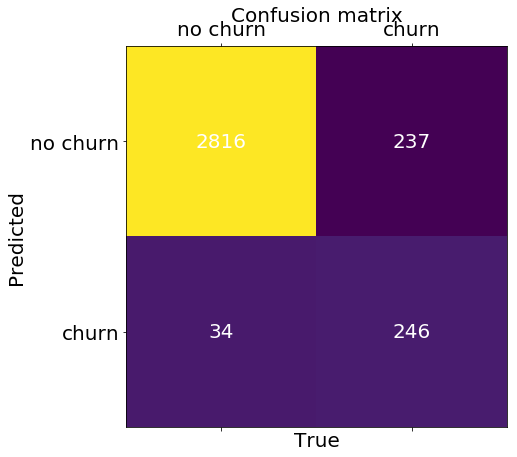

             precision    recall  f1-score   support

          0       0.92      0.99      0.95      2850
          1       0.88      0.51      0.64       483

avg / total       0.92      0.92      0.91      3333



In [48]:
import matplotlib.pyplot as plt
def draw_confusion(y,yhat,labels):
    cm = metrics.confusion_matrix(y, yhat)
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.matshow(cm)
    plt.title('Confusion matrix',size=20)
    ax.set_xticklabels([''] + labels, size=20)
    ax.set_yticklabels([''] + labels, size=20)
    plt.ylabel('Predicted',size=20)
    plt.xlabel('True',size=20)
    for i in range(2):
        for j in range(2):
            ax.text(i, j, cm[i,j], va='center', ha='center',color='white',size=20)
    fig.set_size_inches(7,7)
    plt.show()

draw_confusion(y,yhat,['no churn', 'churn'])
print (metrics.classification_report(y,yhat))

Let us cross-validate the parameters and check if we can do better.

In [52]:
from sklearn import grid_search
parameters = {'C':[ 2,4,8],'gamma':[0.02, 0.05, 0.1], 'class_weight':[{0:0.5},{0:1},{0:2}]}

kf=model_selection.KFold( n_splits=5, shuffle=False, random_state=0)
kf.get_n_splits(X)
acc = np.zeros((5,))
i=0
#We will build the predicted y from the partial predictions on the test of each of the folds
yhat = y.copy()
for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    #Standard parameters
    clf = svm.SVC(kernel='rbf', class_weight={0:1,1:10})
    # We can change the scoring "average_precision", "recall", "f1"
    clf = model_selection.GridSearchCV(clf, parameters, scoring='average_precision')
    clf.fit(X_train,y_train.ravel())
    X_test = scaler.transform(X_test)
    yhat[test_index] = clf.predict(X_test)
    #recall, f1, precision
    acc[i] = metrics.accuracy_score(yhat[test_index], y_test)
    print (str(clf.best_params_))
    i=i+1
print ('Mean accuracy: '+ str(np.mean(acc)))

{'C': 2, 'class_weight': {0: 2}, 'gamma': 0.05}
{'C': 4, 'class_weight': {0: 0.5}, 'gamma': 0.05}
{'C': 2, 'class_weight': {0: 1}, 'gamma': 0.05}
{'C': 2, 'class_weight': {0: 1}, 'gamma': 0.05}
{'C': 2, 'class_weight': {0: 1}, 'gamma': 0.05}
Mean accuracy: 0.920791406099


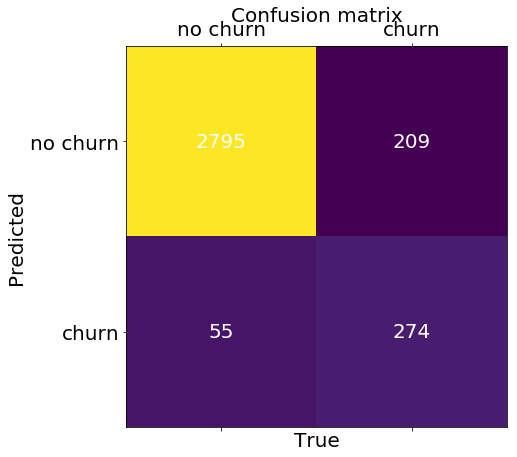

             precision    recall  f1-score   support

          0       0.93      0.98      0.95      2850
          1       0.83      0.57      0.67       483

avg / total       0.92      0.92      0.91      3333



In [53]:
import matplotlib.pyplot as plt
def draw_confusion(y,yhat,labels):
    cm = metrics.confusion_matrix(y, yhat)
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.matshow(cm)
    plt.title('Confusion matrix',size=20)
    ax.set_xticklabels([''] + labels, size=20)
    ax.set_yticklabels([''] + labels, size=20)
    plt.ylabel('Predicted',size=20)
    plt.xlabel('True',size=20)
    for i in range(2):
        for j in range(2):
            ax.text(i, j, cm[i,j], va='center', ha='center',color='white',size=20)
    fig.set_size_inches(7,7)
    plt.show()

draw_confusion(y,yhat,['no churn', 'churn'])
print (metrics.classification_report(y,yhat))

<div class = "alert alert-success"> **QUESTION:** We are dealing with an unbalanced problem. Change the code to bias the model to deal with unbalancing.
</div>

# PART 2. Introduction to ensemble learning

When we want to purchase a product we usually read user's reviews. Before undergoing a major surjery procedure we seek the opinion of different experts. Ensemble learning mimicks one of the human uncertainty reduction mechanism, seeking additional opinions before making a major decision.

Ensemble learning is divided in two steps:

1. Train a set of classifiers
2. Aggregate their results

There are different reasons for using ensemble learning in practice:

1. **Statistical reasons:** The combination of outputs of different classifiers may reduce the risk of an unfortunate selection of a poorly performing classifier.
2. **Large scale data sets:** It makes little sense to only have one classifier on very large sets of data. Partition data in smaller subsets and aggregate seems like a good idea.
3. **Divide and conquer:** Some problems too difficult for a single classifier to solve. The decision boundary may be too complex or lie outside the space of functions of the classifier.
4. **Data fusion:** Different source fusion is usually a problem. One usually faces data coming from heterogeneous sources and the question is how to fuse these data. One solution is to train one classifier per source and the fuse the decision of those experts.

## 1.1 Diversity

One condition required for the system to work is that errors on different classifiers should be made on different samples in order for the strategic combination of the classifiers to correct possible errors in the judgement of the class o a particular instance. This effect has been called **diversity**.

Diversity can be obtained in different ways:

+ Using different training sets. Use resampling strategies to obtain different optimal classifiers. This effect is correlated with the notion of stability of the classifier and the concept of bias and variance of the classifier.
+ Using different training parameters for different classifiers
+ Combining different architectures. (i.e. svm, decission trees, ...)
+ Training on different features. (i.e. random subspaces or random projections)

## 1.2 Bootstrapping aggregation 

Bootstrapping means resampling the training data set with replacement. Usually the same number of data as the original data set is used.

**Bootstrapping aggreagtion (aka. Bagging)** is a ensemble technique that uses multiple bootstrapped copies of the training set to build a set of classifiers. One classifier for each bootstrapped training copy. And then, use a combination technique, such as majority voting, in order to take the final decision.

Let us check, how it works.

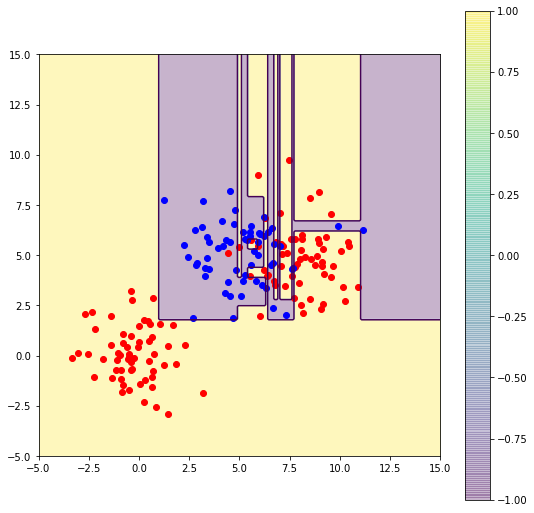

In [54]:
#Let us train an overfitted classifier. For example an SVC.
%reset -f
import numpy as np
import matplotlib.pyplot as plt
MAXN=60
np.random.seed(2)
X = np.concatenate([1.25*np.random.randn(MAXN,2),5+1.5*np.random.randn(MAXN,2)]) 
X = np.concatenate([X,[8,5]+1.5*np.random.randn(MAXN,2)])
y = np.concatenate([np.ones((MAXN,1)),-np.ones((MAXN,1))])
y = np.concatenate([y,np.ones((MAXN,1))])
idxplus = y==1
idxminus = y==-1

from sklearn import tree
from sklearn import metrics

x = np.linspace(-5,15,200)
XX,YY = np.meshgrid(x,x)
sz=XX.shape
data=np.c_[XX.ravel(),YY.ravel()]


clf = tree.DecisionTreeClassifier(criterion="entropy")
clf.fit(X,y.ravel())
Z=clf.predict(data)
mx= np.max(Z)
mn= np.min(Z)
Z.shape=sz
plt.scatter(X[idxplus.ravel(),0],X[idxplus.ravel(),1],color='r')
plt.scatter(X[idxminus.ravel(),0],X[idxminus.ravel(),1],color='b')
plt.imshow(Z, interpolation='bilinear', origin='lower', extent=(-5,15,-5,15),alpha=0.3, vmin=mn, vmax=mx)
plt.colorbar()
plt.contour(XX,YY,Z,[0])

fig = plt.gcf()
fig.set_size_inches(9,9)


Process finnished.


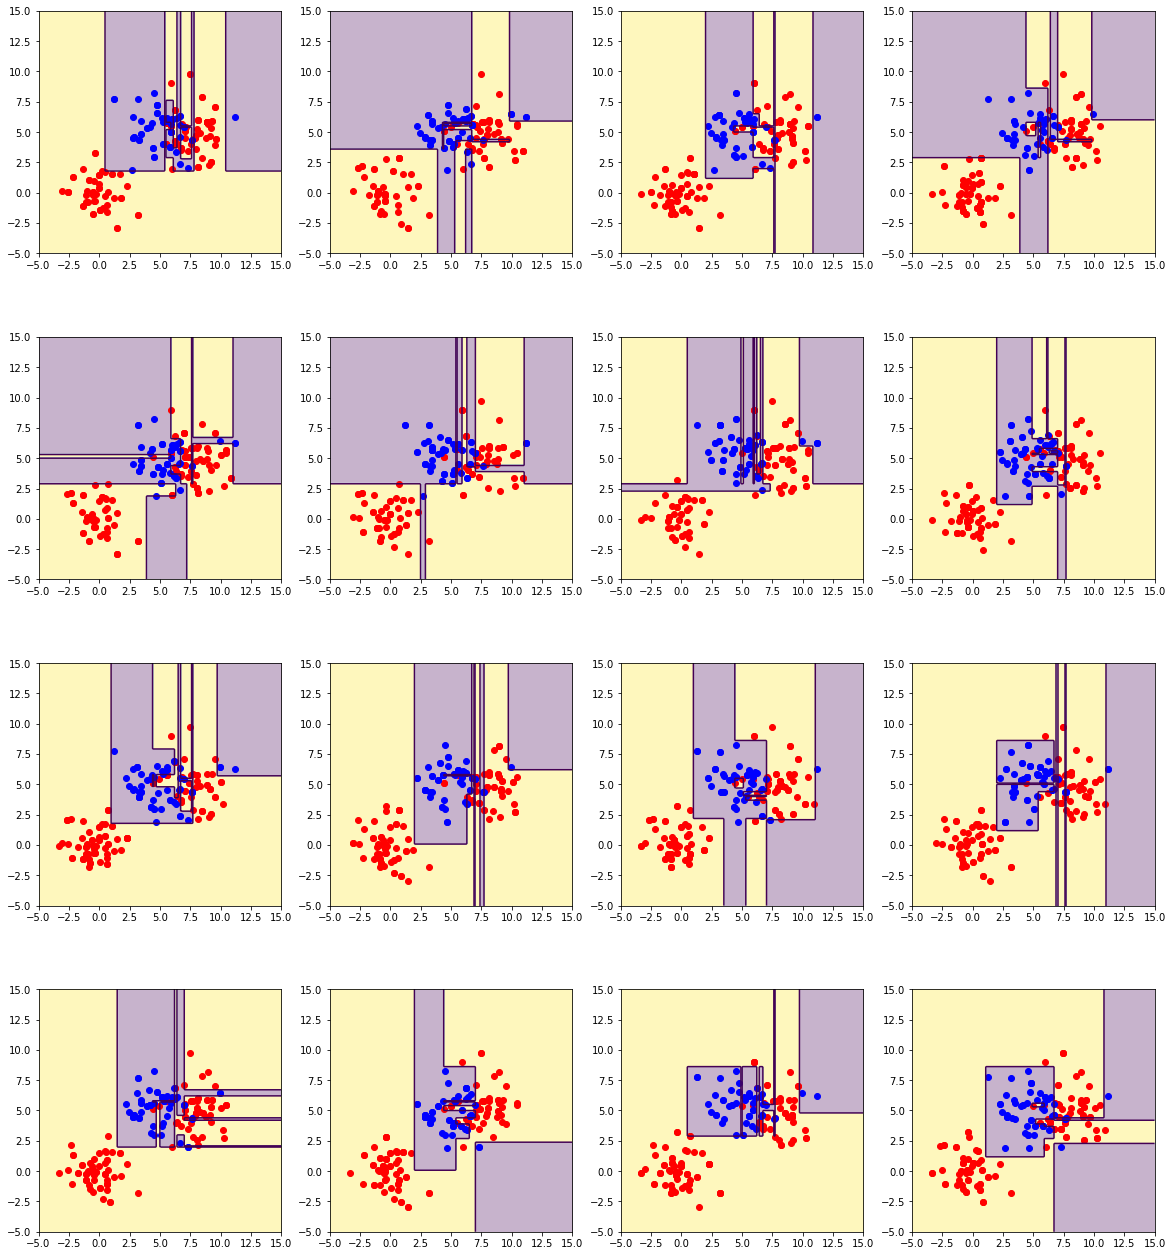

In [57]:
def train_bagged_tree(X,y,C):
    clf_list=[]
    for i in range(C):
        np.random.seed(None)
        idx=np.random.randint(0,y.shape[0],y.shape[0])
        clf = tree.DecisionTreeClassifier(criterion="entropy")
        Xr=X[idx,:]
        yr=y[idx]
        clf_list.append((clf.fit(Xr,yr.ravel()),idx))  #Add the indices for visualization purposes in test
    return clf_list


def visualize_bagged_tree(X,y,clf_list):
    C = len(clf_list)
    x = np.linspace(-5,15,200)
    XX,YY = np.meshgrid(x,x)
    sz=XX.shape
    data=np.c_[XX.ravel(),YY.ravel()]
    yhat=np.zeros((data.shape[0],len(clf_list)))
    i=0
    for dt,idx in clf_list:
        yhat[:,i]=dt.predict(data)
        Xr=X[idx,:]
        yr=y[idx]
        mx= np.max(yhat[:,i])
        mn= np.min(yhat[:,i])
        plt.subplot(int(np.floor(C/4))+1,4,i+1)
        plt.scatter(Xr[(yr==1).ravel(),0],Xr[(yr==1).ravel(),1],color='r')
        plt.scatter(Xr[(yr==-1).ravel(),0],Xr[(yr==-1).ravel(),1],color='b')
        plt.imshow(yhat[:,i].reshape(sz), interpolation='bilinear', origin='lower', extent=(-5,15,-5,15),alpha=0.3, vmin=mn, vmax=mx)
        plt.contour(XX,YY,yhat[:,i].reshape(sz),[0])
        i=i+1
    fig = plt.gcf()
    fig.set_size_inches(20,7*int(np.floor(C/4))+1)
    return yhat


clf_list=train_bagged_tree(X,y,16)
y_pred=visualize_bagged_tree(X,y,clf_list)
y_pred = np.sum(y_pred,axis=1)

print ('Process finnished.')


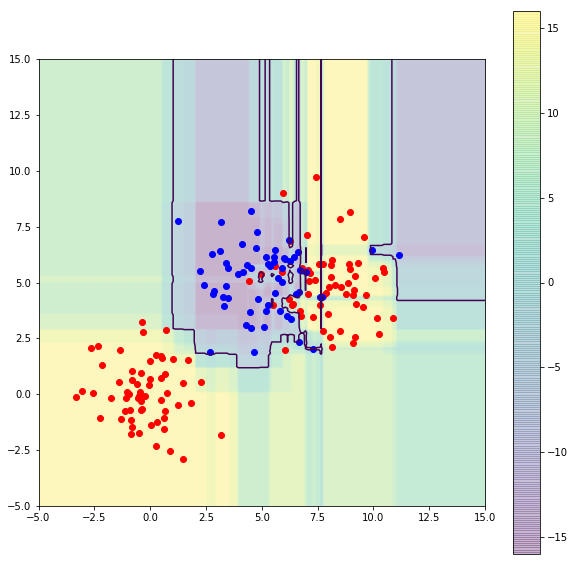

In [58]:
mx= np.max(y_pred)
mn= np.min(y_pred)
plt.figure()
plt.scatter(X[idxplus.ravel(),0],X[idxplus.ravel(),1],color='r')
plt.scatter(X[idxminus.ravel(),0],X[idxminus.ravel(),1],color='b')
plt.imshow(y_pred.reshape(sz), interpolation='bilinear', origin='lower', extent=(-5,15,-5,15),alpha=0.3, vmin=mn, vmax=mx)
plt.colorbar()
plt.contour(XX,YY,y_pred.reshape(sz),[0])
fig = plt.gcf()
fig.set_size_inches(10,10) 

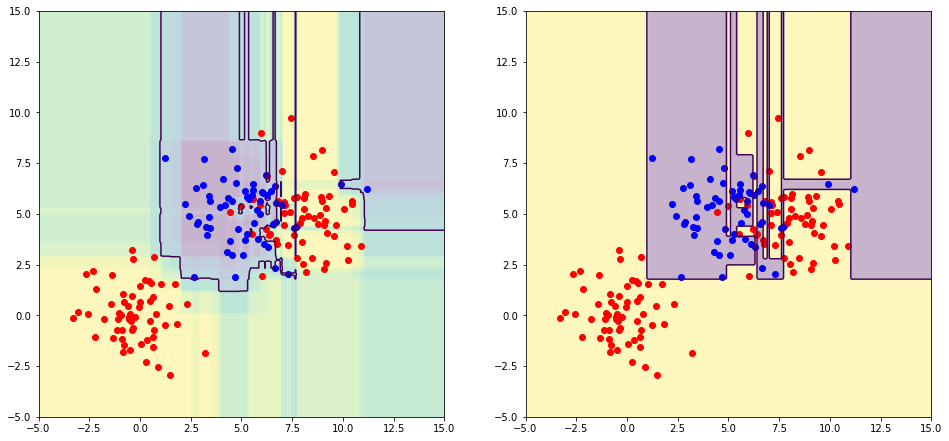

In [59]:
Zb = y_pred.reshape(sz)
plt.subplot(1,2,1)
plt.scatter(X[idxplus.ravel(),0],X[idxplus.ravel(),1],color='r')
plt.scatter(X[idxminus.ravel(),0],X[idxminus.ravel(),1],color='b')
plt.imshow(Zb, interpolation='bilinear', origin='lower', extent=(-5,15,-5,15),alpha=0.3, vmin=mn, vmax=mx)
plt.contour(XX,YY,Zb,[0])
plt.subplot(1,2,2)
plt.scatter(X[idxplus.ravel(),0],X[idxplus.ravel(),1],color='r')
plt.scatter(X[idxminus.ravel(),0],X[idxminus.ravel(),1],color='b')
plt.imshow(Z, interpolation='bilinear', origin='lower', extent=(-5,15,-5,15),alpha=0.3, vmin=-1, vmax=1)
plt.contour(XX,YY,Z,[0])
fig = plt.gcf()
fig.set_size_inches(16,9)

### 1.2.1 Application to customer churn prediction

Let us check this approach in the Churn problem. Recall that a single decision tree achieved an accuracy of $91.7\%$, precision of $71\%$ and recall of $72\%$

In [60]:
%reset -f
#Recover Churn data
import pickle
fname = open('churn_data.pkl','rb')
data = pickle.load(fname)
X = data[0]
y = 2*data[1]-1
features = data[2]
print ('Loading ok.')

Loading ok.


In [61]:
def train_bagged_tree(X,y,C):
    clf_list=[]
    for i in range(C):
        np.random.seed(None)
        idx=np.random.randint(0,y.shape[0],y.shape[0])
        clf = tree.DecisionTreeClassifier(criterion="entropy")
        Xr=X[idx,:]
        yr=y[idx]
        clf_list.append(clf.fit(Xr,yr.ravel()))  
    return clf_list


def test_bagged_tree(X,clf_list):
    yhat=np.zeros((X.shape[0],len(clf_list)))
    i=0
    for dt in clf_list:
        yhat[:,i]=dt.predict(X)
        i=i+1
    return np.sign(np.mean(yhat,axis=1))

In [64]:
#NO SNOOPING
import numpy as np
from sklearn import model_selection
from sklearn import tree
from sklearn import metrics

kf=model_selection.KFold(n_splits=5, shuffle=False, random_state=0)
kf.get_n_splits(X)
acc = np.zeros((5,))
i=0
#We will build the predicted y from the partial predictions on the test of each of the folds
yhat = y.copy()
for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    clf_list = train_bagged_tree(X_train,y_train.ravel(),21)
    yhat[test_index]=test_bagged_tree(X_test,clf_list) 
    acc[i] = metrics.accuracy_score(yhat[test_index], y_test)
    i=i+1
print ('Mean accuracy: '+ str(np.mean(acc)))

Mean accuracy: 0.952295023659


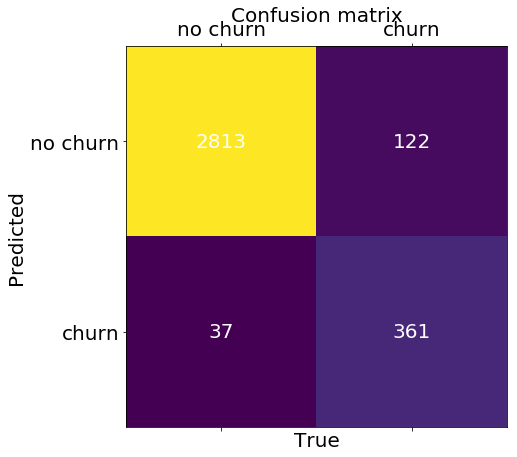

             precision    recall  f1-score   support

         -1       0.96      0.99      0.97      2850
          1       0.91      0.75      0.82       483

avg / total       0.95      0.95      0.95      3333



In [66]:
import matplotlib.pyplot as plt
def draw_confusion(y,yhat,labels):
    cm = metrics.confusion_matrix(y, yhat)
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.matshow(cm.T)
    plt.title('Confusion matrix',size=20)
    ax.set_xticklabels([''] + labels, size=20)
    ax.set_yticklabels([''] + labels, size=20)
    plt.ylabel('Predicted',size=20)
    plt.xlabel('True',size=20)
    for i in range(2):
        for j in range(2):
            ax.text(i, j, cm[i,j], va='center', ha='center',color='white',size=20)
    fig.set_size_inches(7,7)
    plt.show()

draw_confusion(y,yhat,['no churn', 'churn'])
print (metrics.classification_report(y,yhat))

Observe that the solution accuracy increases by about $5\%$, recall goes upt to $75\%$ and precision also increases up to $91\%$.

<div class="alert alert-info"> **Bagging** performance improvement is due to the reduction of the variance of the classifier while mantaining its bias.
</div>

## 1.3. Random Forest

Random Forest technique introduces a randomization over the feature selected for building  each tree in the ensemble in order to improve diversity in an attempt to reduce variance evan more. Let us code this variant of bagging.

In [76]:
%reset -f
from sklearn import tree
import numpy as np
def train_random_forest(X,y,C,F):
    F=int(np.ceil(np.sqrt(X.shape[1])))
    clf_list=[]
    for i in range(C):
        np.random.seed(None)
        idx=np.random.randint(0,y.shape[0],y.shape[0])
        feat_idx=np.random.permutation(np.arange(X.shape[1]))[:F]
        clf = tree.DecisionTreeClassifier(criterion="entropy")
        Xr=X[idx,:].copy()
        Xr=Xr[:,feat_idx]
        yr=y[idx]
        clf_list.append((clf.fit(Xr,yr.ravel()),feat_idx))
    return clf_list


def test_random_forest(X,clf_list):
    yhat=np.zeros((X.shape[0],len(clf_list)))
    i=0
    for dt,feat_idx in clf_list:
        yhat[:,i]=dt.predict(X[:,feat_idx])
        i=i+1
    return np.sign(np.mean(yhat,axis=1)),yhat

In [77]:
#Recover Churn data
import pickle
fname = open('churn_data.pkl','rb')
data = pickle.load(fname)
X = data[0]
y = 2*data[1]-1
print ('Labels: '+ str(np.unique(y)))
features = data[2]
print ('Loading ok.')

Labels: [-1  1]
Loading ok.


In [80]:
from sklearn import metrics
clf_list = train_random_forest(X,y,51,5)
yhat,yk = test_random_forest(X,clf_list)
acc = metrics.accuracy_score(yhat, y)
print (yk.shape)
print (np.sum(np.mean(yk,axis=1)>0))
print (acc)

(3333, 51)
482
0.999699969997


In [82]:
#NO SNOOPING
from sklearn import model_selection
from sklearn.preprocessing import StandardScaler
from sklearn import ensemble
from sklearn import metrics


kf=model_selection.KFold(n_splits=5, shuffle=False, random_state=0)
kf.get_n_splits(X)
acc = np.zeros((5,))
i=0
#We will build the predicted y from the partial predictions on the test of each of the folds
yhat = y.copy()
for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    #dt = ensemble.RandomForestClassifier(n_estimators=51)
    #dt.fit(X_train,y_train)
    #yhat[test_index]=dt.predict(X_test)
    clf_list = train_random_forest(X_train,y_train,51,np.ceil(np.sqrt(X.shape[1])))
    yhat[test_index],yk = test_random_forest(X_test,clf_list)
    acc[i] = metrics.accuracy_score(yhat[test_index], y_test)
    i=i+1
print (acc)
print (np.unique(yhat))
print (np.unique(y_test))
print ('Mean accuracy: '+ str(np.mean(acc)))

[ 0.87556222  0.90254873  0.85607196  0.84984985  0.85135135]
[-1  1]
[-1  1]
Mean accuracy: 0.867076821949


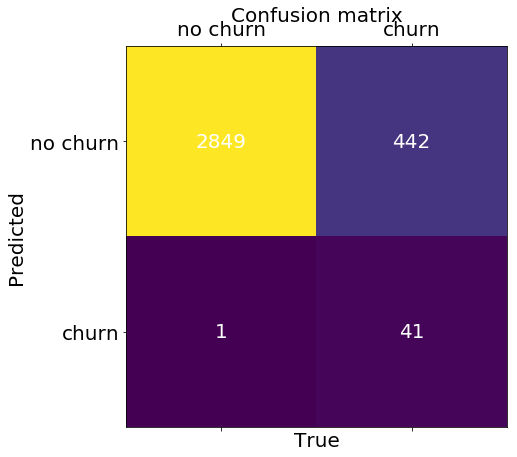

             precision    recall  f1-score   support

         -1       0.87      1.00      0.93      2850
          1       0.98      0.08      0.16       483

avg / total       0.88      0.87      0.82      3333



In [84]:
import matplotlib.pyplot as plt
def draw_confusion(y,yhat,labels):
    cm = metrics.confusion_matrix(y, yhat)
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.matshow(cm.T)
    plt.title('Confusion matrix',size=20)
    ax.set_xticklabels([''] + labels, size=20)
    ax.set_yticklabels([''] + labels, size=20)
    plt.ylabel('Predicted',size=20)
    plt.xlabel('True',size=20)
    for i in range(2):
        for j in range(2):
            ax.text(i, j, cm[i,j], va='center', ha='center',color='white',size=20)
    fig.set_size_inches(7,7)
    plt.show()
draw_confusion(y,yhat,['no churn', 'churn'])
print (metrics.classification_report(y,yhat))

# 3. Reductionist frameworks for the multi-class problems 

Up to this moment we have applied several models in multi-class problems but we have barely talked about the problem of multiple classes in learning. 

First of all, there are very few models that intrinsically handle the multi-class case. By intrinsically handling the multi-class problem I am referring to methods in which we do not have to worry about how many classes our problem has. The two big families of models that can deal with the problem are

+ Decision trees: the leaves encode the class.
+ Nearest Neighbors: we only care about class labels of instances close to my query sample.

What about the rest of the models? Did not Bayesian models or Neural Networks also handle this problem? Yes, they work in the multi-class case. But we have to worry about how many classes there are. In particular we have to build a model for each class and then take a maximum score/probability/confidence among the predictions. This way of addressing the multiclass problem is also known as **one-against-all** because we consider one model for each class while the samples from the rest of the classes are considered as negative samples. This is the first example of a reductionist framework.

The reductionist framework refers to those ensemble methods that allows to reduce the multi-class problem to a set of binary problems. In a $K$ class problem, the two most common approaches in this framework are:

+ **one-against-all:** We consider $K$ partitions of the problem, corresponding to setting one class as positive class and the rest as negative. 
+ **one-against-one:** We consider all posible pairs of classes and build a model for each subproblem. 

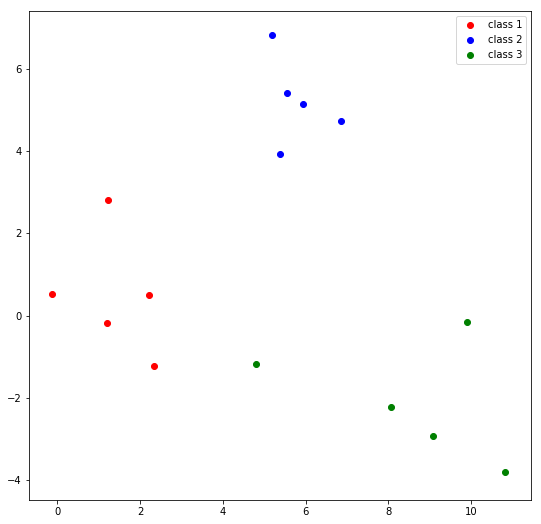

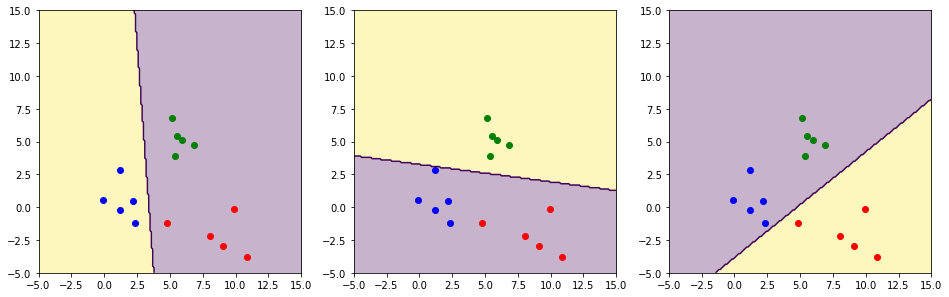

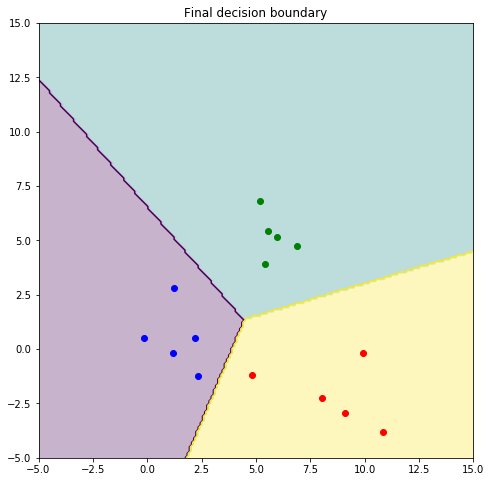

In [85]:
%reset -f
#Create a multiclass toy problem
import numpy as np
import matplotlib.pyplot as plt
from sklearn import svm
MAXN=5
np.random.seed(0)
X = np.concatenate([1.25*np.random.randn(MAXN,2),5+1.25*np.random.randn(MAXN,2)]) 
X = np.concatenate([X,[8,-2]+1.25*np.random.randn(MAXN,2)])
y = np.concatenate([np.ones((MAXN,1)),2*np.ones((MAXN,1))])
y = np.concatenate([y,3*np.ones((MAXN,1))])

#Display data
plt.scatter(X[(y==1).ravel(),0],X[(y==1).ravel(),1],color='r',label='class 1')
plt.scatter(X[(y==2).ravel(),0],X[(y==2).ravel(),1],color='b',label='class 2')
plt.scatter(X[(y==3).ravel(),0],X[(y==3).ravel(),1],color='g',label='class 3')
plt.legend()
fig = plt.gcf()
fig.set_size_inches(9,9)

#Train a LinearSVC in one-vs-all fashion
clf_list=[]
for i in range(3):
    clf = svm.LinearSVC()
    y_meta = y.copy()
    #Create a binary problem with one class at +1 and the rest at -1
    y_meta=np.where(y_meta == i+1 ,1,-1)
    clf_list.append(clf.fit(X,y_meta.ravel()))

#Test each classifier
plt.figure()
x = np.linspace(-5,15,200)
XX,YY = np.meshgrid(x,x)
sz=XX.shape
data=np.c_[XX.ravel(),YY.ravel()]
i=1
yhat_d=np.empty((data.shape[0],3))
for c in clf_list:
    yhat=c.predict(data)
    #Visualization of each boundary
    yhat_d[:,i-1]=c.decision_function(data)
    mn = np.min(yhat)
    mx = np.max(yhat)
    plt.subplot(1,3,i)
    plt.scatter(X[(y==1).ravel(),0],X[(y==1).ravel(),1],color='b',label='class 1')
    plt.scatter(X[(y==2).ravel(),0],X[(y==2).ravel(),1],color='g',label='class 2')
    plt.scatter(X[(y==3).ravel(),0],X[(y==3).ravel(),1],color='r',label='class 3')
    plt.imshow(yhat.reshape(sz), interpolation='bilinear', origin='lower', extent=(-5,15,-5,15),alpha=0.3, vmin=mn, vmax=mx)
    plt.contour(XX,YY,yhat.reshape(sz),[0])
    i=i+1
fig = plt.gcf()
fig.set_size_inches(16,9)

y_final=np.argmax(yhat_d,axis=1)
plt.figure()
plt.scatter(X[(y==1).ravel(),0],X[(y==1).ravel(),1],color='b',label='class 1')
plt.scatter(X[(y==2).ravel(),0],X[(y==2).ravel(),1],color='g',label='class 2')
plt.scatter(X[(y==3).ravel(),0],X[(y==3).ravel(),1],color='r',label='class 3')
plt.imshow(y_final.reshape(sz), interpolation='bilinear', origin='lower', extent=(-5,15,-5,15),alpha=0.3, vmin=0, vmax=2)
plt.contour(XX,YY,y_final.reshape(sz),[0, 1])
plt.title("Final decision boundary")
fig = plt.gcf()
fig.set_size_inches(16,8)

## 3.1 Error correcting output coding

Error correcting output coding is a generalization of the methods shown before. In the most general case each class is assigned a ternary code $c_i \in \{+1,0,-1\}^l$ with length $l$. This step is called **coding**. In testing a new sample will be given a test code and this will be compared according to some distance to the class codewords. The class with the closest codeword will be selected as the predicted class. This step is called **decoding**.



### 3.1.1 Understanding the coding step
If we arrange the codewords as rows in a matrix we obtain the coding matrix $M \in \{+1,0,-1\}^{K\times l}$. Consider the following example with four classes and code length $l=3$:

<table>
  <tr>
    <th></th>
    <th>$h_1$</th>
    <th>$h_2$</th>
    <th>$h_3$</th>
  </tr>
  <tr>
    <th>$y_1$</th>
    <th>$1$</th>
    <th>$1$</th>
    <th>$1$</th>
  </tr>
    <tr>
    <th>$y_2$</th>
    <th>$1$</th>
    <th>$-1$</th>
    <th>$0$</th>
  </tr>
    <tr>
    <th>$y_3$</th>
    <th>$-1$</th>
    <th>$0$</th>
    <th>$1$</th>
  </tr>
    <tr>
    <th>$y_4$</th>
    <th>$-1$</th>
    <th>$0$</th>
    <th>$-1$</th>
  </tr>
</table>

The first class, $y_1$ is coded as $(1,1,1)$, the second $y_2$ is coded as $(1,-1,0)$, and so on.

Note that the columns of the matrix define a binary problem involving all the classes in the following way: in same column, all classes with code $+1$ belongs to the same meta-class, all classes with code $-1$ to the other meta-class, and all classes with code $0$ are not considered in that particular problem. In our example, the first column defines a binary problem involving the discrimination of all samples from classes $y_1,y_2$ (coded as $+1$) against all the samples of $y_3,y_4$ (coded as $-1$). The second column only considers the samples of class $y_1$ against the samples of class $y_2$. Note that all the zero coded classes are not considered. 

Given a coding matrix a classifier is trained for each column according to the column defined binary problem. 


<div class="alert alert-success">**EXERCISE:** Which are the coding matrix of one-vs-one and one-vs-all?
</div>

### 3.1.2 Understanding the decoding step

Given a set of classifiers trained according to the problems defined by the columns of the coding matrix, in the prediction step all the classifiers are applyed to the testing sample. As a result a binary code $t$ is obtained. This coded is compared to all the class codes according to some decoding/distance metric. The most common ones are:

+ Hamming decoding/$\ell_1$-decoding
$$d(a,b) = \frac{1}{2}\sum\limits_{i=1}^l |a_i-b_i|$$

+ Euclidean decoding
$$d(a,b) = \sqrt{\sum\limits_{i=1}^l (a_i-b_i)^2}$$

For example, consider that $t=(-1,-1,-1)$. Note that there is no exact code in the coding matrix, thus we have to check for the closest one. If we apply Hamming decoding we obtain

<table>
  <tr>
    <th></th>
    <th>Hamming</th>
    <th>Euclidean</th>
  </tr>
  <tr>
    <th>$y_1$</th>
    <th>$3$</th>
    <th>$\sqrt{12}$</th>
  </tr>
    <tr>
    <th>$y_2$</th>
    <th>$\frac{3}{2}$</th>
    <th>$\sqrt{5}$</th>
  </tr>
    <tr>
    <th>$y_3$</th>
    <th>$\frac{3}{2}$</th>
    <th>$\sqrt{5}$</th>
  </tr>
    <tr>
    <th>$y_4$</th>
    <th>$\frac{1}{2}$</th>
    <th>$1$</th>
  </tr>
</table>

Observe that in both cases the sample will be predicted as class $y_4$.

Let us apply this framework to the former problem using a one-vs-all approach:

Coding matrix M = 
[[ 1 -1 -1]
 [-1  1 -1]
 [-1 -1  1]]


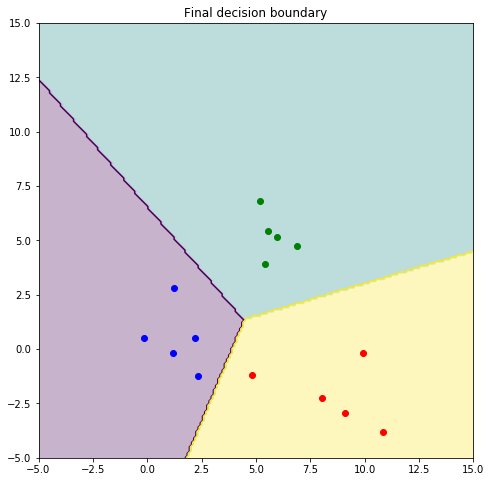

In [89]:
%reset -f
#Create a multiclass toy problem
import numpy as np
import matplotlib.pyplot as plt
from sklearn import svm
MAXN=5
np.random.seed(0)
X = np.concatenate([1.25*np.random.randn(MAXN,2),5+1.25*np.random.randn(MAXN,2)]) 
X = np.concatenate([X,[8,-2]+1.25*np.random.randn(MAXN,2)])
y = np.concatenate([0*np.ones((MAXN,1)),1*np.ones((MAXN,1))])
y = np.concatenate([y,2*np.ones((MAXN,1))])
x = np.linspace(-5,15,200)
XX,YY = np.meshgrid(x,x)
sz=XX.shape
data=np.c_[XX.ravel(),YY.ravel()]

#Define the coding matrix
M = np.array([[1, -1, -1],[-1, 1, -1],[-1, -1, 1]]) #1vsAll
#M = np.array([[1, 1, 0 ],[-1, 0, 1],[0, -1, -1]]) #1vs1

print ('Coding matrix M = \n' + str(M))
def inset(a,b): 
    return [item in b for item in a]

def fit_ECOC(X, y, M):
    clf_list=[]
    for i in range(M.shape[1]): #For each column
        y_meta=y.copy()
        idx_c1 = np.where(inset(y, np.where(M[:,i]==1)[0]))[0]
        idx_c2 = np.where(inset(y, np.where(M[:,i]==-1)[0]))[0]
        clf = svm.LinearSVC()
        clf_list.append(clf.fit(np.r_['0',X[idx_c1,:],X[idx_c2,:]],np.r_['0',np.ones((idx_c1.shape[0],1)),-np.ones((idx_c2.shape[0],1))].ravel()))
    return clf_list

def predict_ECOC(X,M, clf_list):
    #Test codes
    c = np.zeros((X.shape[0],M.shape[1]))
    for i in range(M.shape[1]):
        c[:,i]=clf_list[i].decision_function(X) #SOFT CODES
        #c[:,i]=clf_list[i].predict(X) #HARD CODES 
    #Use Euclidean distance
    i=0
    d = np.zeros((X.shape[0],M.shape[0]))
    for code in M:
        d[:,i]=np.sum(np.power((c-code),2),axis=1)
        i=i+1
    return np.argmin(d,axis=1)    


clf_list=fit_ECOC(X,y,M)
y_final = predict_ECOC(data,M,clf_list)

plt.scatter(X[(y==0).ravel(),0],X[(y==0).ravel(),1],color='b',label='class 1')
plt.scatter(X[(y==1).ravel(),0],X[(y==1).ravel(),1],color='g',label='class 2')
plt.scatter(X[(y==2).ravel(),0],X[(y==2).ravel(),1],color='r',label='class 3')
plt.imshow(y_final.reshape(sz), interpolation='bilinear', origin='lower', extent=(-5,15,-5,15),alpha=0.3, vmin=0, vmax=2)
plt.contour(XX,YY,y_final.reshape(sz),[0, 1])
plt.title("Final decision boundary")
fig = plt.gcf()
fig.set_size_inches(16,8)

<div class="alert alert-success">
**EXERCISE:** Replace the hard codes prediction by the soft coding by changing in the ECOC_predict() function the ".predict" by ".decision_function". Run the algorithm with one-against-all approach. What do you observe?
</div>

<div class="alert alert-success">
**EXERCISE:** Replace the coding matrix by one-vs-one.
</div>

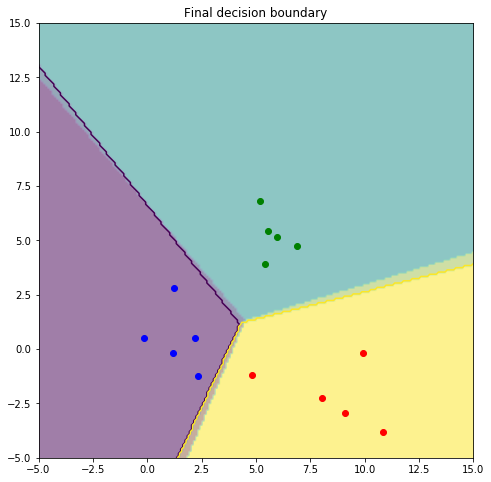

In [90]:
M = np.array([[1, 1, 0 ],[-1, 0, 1],[0, -1, -1]])
clf_list=fit_ECOC(X,y,M)
y_final2 = predict_ECOC(data,M,clf_list)

plt.scatter(X[(y==0).ravel(),0],X[(y==0).ravel(),1],color='b',label='class 1')
plt.scatter(X[(y==1).ravel(),0],X[(y==1).ravel(),1],color='g',label='class 2')
plt.scatter(X[(y==2).ravel(),0],X[(y==2).ravel(),1],color='r',label='class 3')
plt.imshow(y_final2.reshape(sz), interpolation='bilinear', origin='lower', extent=(-5,15,-5,15),alpha=0.3, vmin=0, vmax=2)

plt.imshow(y_final.reshape(sz), interpolation='bilinear', origin='lower', extent=(-5,15,-5,15),alpha=0.3, vmin=0, vmax=2)
plt.contour(XX,YY,y_final2.reshape(sz),[0, 1])
plt.title("Final decision boundary")
fig = plt.gcf()
fig.set_size_inches(16,8)